In [1]:
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *

In [3]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [4]:
path = untar_data(URLs.IMDB)

In [11]:
files = get_text_files(path, folders=['train','test'])

In [5]:
def f(x:int):
    return x+1
tfm = Transform(f)
tfm(2), tfm(2.0), tfm

(3,
 2.0,
 f:
 encodes: (int,object) -> fdecodes: )

In [6]:
class NormalizeMean(Transform):
    def setups(self, items):
        self.mean = sum(items)/len(items)
    
    def encodes(self,x):
        return x-self.mean
    
    def decodes(self,x):
        return x+self.mean

In [10]:
tfm = NormalizeMean()
tfm.setup([12,3,4])
tfm(2)
tfm.decode(5)

11.333333333333332

In [13]:
tls = TfmdLists(files,[Tokenizer.from_folder(path), Numericalize])

In [20]:
splits = [list(range(10)), list(range(10, 20))]

In [23]:
lbls = files.map(parent_label)

In [26]:
cat = Categorize()
cat.setup(lbls)
cat.vocab

['neg', 'pos']

In [27]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])

In [29]:
x,y = dsets[0]

`TfmdLists`: process a list of data
`DataSets`: process training data and validation data togethter
`DataLoaders`: collate data into batches, you can do something on each batch

In [30]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [31]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/'images')

In [63]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size:
                img2 = img2.resize(img1.size)
            
            t1, t2 = tensor(img1), tensor(img2)
            t1,t2 = t1.permute(2,0,1), t2.permute(2,0,1)
        else:
            t1,t2 = img1, img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=same_breed,ctx=ctx)

In [64]:
img1 = PILImage.create(files[0])

<AxesSubplot:title={'center':'True'}>

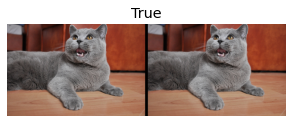

In [65]:
s = SiameseImage(img1,img1,True)
s.show()

In [72]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [94]:
def lbl2files(files,labels):
    return {l: L(f for f in files if label_func(f) == l)
               for l in labels
           }

def lbl2files2(files,labels):
    dic = {}
    for lbl in labels:
        dic[lbl] = L()
    for f in files:
        l = label_func(f)
        dic[l].append(l)
    return dic
    

In [74]:
labels = files.map(label_func).unique()

In [95]:
dic1 = lbl2files(files,labels)
items1 = [k for k,v in dic1.items()]

dic2 = lbl2files2(files,labels)
items2 = [k for k,v in dic1.items()]

In [97]:
class SiameseTransform(Transform):
    def __init__(self,files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = lbl2files(files,self.labels)
        
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    
    def encodes(self,f):
        f2,t = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1,img2,t)
    
    def _draw(self,f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same:
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]), same

In [98]:
splits = RandomSplitter()(files)

In [100]:
tmf = SiameseTransform(files, label_func, splits)

<AxesSubplot:title={'center':'False'}>

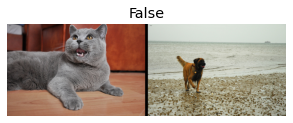

In [105]:
tmf(files[0]).show()

In [107]:
tls = TfmdLists(files, tmf, splits=splits)
len(tls.train), len(tls.valid)

(5912, 1478)

<AxesSubplot:title={'center':'False'}>

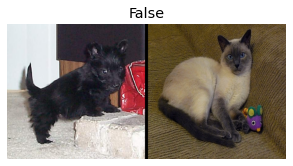

In [109]:
tls.train[0].show()